In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

sns.set_style("darkgrid")

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
import string

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from IPython.display import display_html

In [2]:
df1 = pd.read_csv('./data/askhistorians_clean.csv')
df2 = pd.read_csv('./data/whatif_clean.csv')

<h1>Project Three: History, or Story?</h1>

In [3]:
# merge into one dataset with a single column for target
df2['whatif'] = 1
df2['whatif'].value_counts()

1    8961
Name: whatif, dtype: int64

In [4]:
# fill the ask-historians entries as 0
df1['whatif'] = 0

In [5]:
# clean text

# function courtesy of Marta Ghiglioni
def cleaner(text):
    # Make lowercase
    text = text.lower()
    # Remove HTML special characters
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove punctuation and split
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    # Remove characters beyond Basic Multilingual Plane
    text = ''.join(c for c in text if c <= '\uFFFF') 
    return text

df1['selftext'] = df1['selftext'].apply(cleaner)
df2['selftext'] = df2['selftext'].apply(cleaner)

In [6]:
# merge the dataframes
df = df1.append(df2)

In [7]:
# drop the irrelevant columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'subreddit',
       'created_utc', 'author', 'num_comments', 'score', 'is_self',
       'timestamp'], inplace=True)

In [8]:
X = df['selftext']
y = df['whatif']

In [9]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
# Baseline accuracy
y_test.value_counts(normalize=True)

0    0.615879
1    0.384121
Name: whatif, dtype: float64

In [11]:
# excluding what and if is going to make this a lot harder, but it feels
# like the right thing to do in the spirit of the goal I am aiming at.
custom = ['history', 'what', 'if', 'reddit', 'subreddit']
combined_words = text.ENGLISH_STOP_WORDS.union(custom)

In [12]:
knn_cvec = CountVectorizer(analyzer = "word",
                       preprocessor = None,
                       stop_words = combined_words, 
                       max_features = 500, 
                       ngram_range = (1, 4)
                      )

knn = KNeighborsClassifier()

knn_sc = StandardScaler(with_mean=False)

knn_pipe = Pipeline([
    ('cvec', knn_cvec),
    ('sc', knn_sc),
    ('knn', knn)
])

knn_pipe.fit(X_train, y_train)

knn_train = knn_pipe.score(X_train, y_train)
knn_test = knn_pipe.score(X_test, y_test)
print(f'KNN, score on training set: {knn_train}, score on test set: {knn_test}.')

KNN, score on training set: 0.8026146592370339, score on test set: 0.6925961641487196.


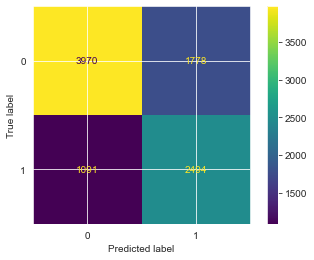

In [13]:
plot_confusion_matrix(knn_pipe, X_test, y_test)

In [25]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_split=13,
                            min_samples_leaf=5,
                            ccp_alpha=0.05,
                            random_state=42)
p_stemmer = PorterStemmer()
dt_cvec = CountVectorizer(analyzer="word",
                          preprocessor=None,
                          stop_words=combined_words,
                          max_features=100,
                          ngram_range=(1, 1)
                          )
dt_pipe = Pipeline([
    ('cvec', dt_cvec),
    ('dt', dt)
])

dt_pipe.fit(X_train, y_train)

dt_train = dt_pipe.score(X_train, y_train)
dt_test = dt_pipe.score(X_test, y_test)

print(
    f'Decision Trees, Score on training set: {dt_train}, score on test set: {dt_test}')

Decision Trees, Score on training set: 0.6159451350192885, score on test set: 0.6158791385406621


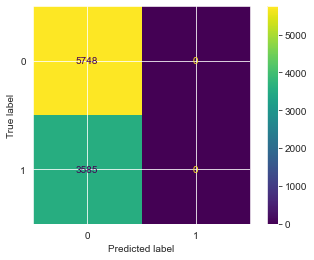

In [15]:
plot_confusion_matrix(dt_pipe, X_test, y_test)

In [26]:
rf_cvec = CountVectorizer(analyzer = "word",
                       preprocessor = None,
                       stop_words = combined_words, 
                       max_features = 1000, 
                       ngram_range = (1, 4)
                      )
                    
rf = RandomForestClassifier(random_state = 42, n_estimators = 25)
rf_pipe = Pipeline([
    ('cvec', rf_cvec),
    ('rf', rf)
])
rf_pipe.fit(X_train, y_train)
rf_train = rf_pipe.score(X_train, y_train)
rf_test = rf_pipe.score(X_test, y_test)
print(f'Random Forest, score on training set: {rf_train}, score on test set: {rf_test}.')

Random Forest, score on training set: 0.991213030432919, score on test set: 0.8227793849780349.


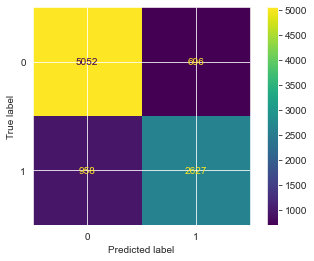

In [27]:
plot_confusion_matrix(rf_pipe, X_test, y_test)

In [ ]:
svc_cvec = CountVectorizer(analyzer = "word",
                       preprocessor = None,
                       stop_words = combined_words, 
                       max_features = 2000, 
                       ngram_range = (1, 1),
                      )

pgrid = {"svc__C": np.linspace(0.01, 1, 20)}

svc = SVC(max_iter=7000, tol=0.1) # model object

svc_sc = StandardScaler(with_mean=False)

svc_pipe = Pipeline([
    ('cvec', svc_cvec),
    ('sc', svc_sc),
    ('svc', svc)
])

svc_grid = GridSearchCV(svc_pipe,
                        pgrid,
                        cv = 5)

svc_grid.fit(X_train, y_train)
svc_train = svc_grid.score(X_train, y_train)
svc_test = svc_grid.score(X_test, y_test)
print(f'SVC, score on training set: {svc_train}, score on test set: {svc_test}.')

In [ ]:
plot_confusion_matrix(svc_grid, X_test, y_test)

In [ ]:
preds = grid.predict(X_test)

In [ ]:
grid = GridSearchCV(estimator=dt,
                    param_grid={'max_depth': [2,3,5,7],
                               'min_samples_split': [5,10,15,20],
                               'min_samples_leaf': [2,3,4,5,6],
                               'ccp_alpha': [0,0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    verbose = 1)

grid.fit(X_train, y_train);

In [ ]:
# # notes for future improvements

# most common ten words

# Tiffydiff

# Lemma/stem

# plot ROC curve

# explain choice of measurement

# pull out misclassifications to examine

# 